# Gingiva vs Mucosa

In [1]:
suppressMessages({
    library(phyloseq)
    library(DESeq2)
    library(SummarizedExperiment)
    library(magrittr)
    library(dplyr)
    library(tidyr)
    library(ggplot2)
})

In [2]:
contingencyTable <- function(x, diffcols, sigcols) {
        
    row_data <- SummarizedExperiment::rowData(x) %>% 
        tibble::as_tibble(rownames = "rowname")
    col_data <- SummarizedExperiment::colData(x) %>% 
        tibble::as_tibble(rownames = "rowname")
    
    for (i in seq_along(diffcols)) {
        row_data[diffcols[i]] <- factor(row_data[[diffcols[i]]], levels = c("TRUE", "FALSE"), labels = c("Diff", "NotDiff"))
    }
    
    for (j in seq_along(sigcols)) {
        row_data[[sigcols[j]]] = factor(row_data[[sigcols[j]]], levels = c("TRUE", "FALSE"), labels = c(sigcols[j], paste0("Not", sigcols[j])))
    }
    
    vctr_len <- length(diffcols) * length(sigcols)
    output <- vector("list", vctr_len)
    counter <- 1
    
    for (i in seq_along(diffcols)) {
        for (j in seq_along(sigcols)){
            
            form <- paste0("~ ", diffcols[i], " + ", sigcols[j])
            contigency_table <- stats::xtabs(form, data = row_data)
            output[[counter]] <- contigency_table
            names(output)[counter] <- paste0(diffcols[i], "_" ,sigcols[j])
            counter <- counter + 1
        }
    }
    
    return(output)
    
}

enrichmentTest <- function(x) {
    
   output <-  lapply(x, function(y) {
       p_value <- fisher.test(y, alternative = "g")$p.value
       odds_ratio <- suppressWarnings(epitools::oddsratio.wald(y + 0.5)$measure[2,1])
       ci_up <- exp(log(odds_ratio) + 1.96 * sqrt(sum(1 / (y + 1) )))
       ci_lo <- exp(log(odds_ratio) - 1.96 * sqrt(sum(1 / (y + 1) )))       
       c(p_value, odds_ratio, ci_up, ci_lo)
    }) %>% 
       as.data.frame() %>% 
       t() %>% 
       tibble::as_tibble(rownames = "rownames") %>% 
       magrittr::set_colnames(c("con.table",  "p.value", "odds.ratio", "ci.up", "ci.lo")) %>% 
       dplyr::arrange(p.value, odds.ratio)
    
    return(output)
    
}

## Data

In [3]:
# HMP16S data
load(url("https://github.com/mcalgaro93/sc2meta/blob/master/data/16Sdatasets_for_replicability_filtered.RData?raw=true"))
str(ps_list_16S, max.level = 1)

List of 3
 $ Stool_TongueDorsum       :Formal class 'phyloseq' [package "phyloseq"] with 5 slots
 $ Gingiva_Mucosa           :Formal class 'phyloseq' [package "phyloseq"] with 5 slots
 $ Subgingival_Supragingival:Formal class 'phyloseq' [package "phyloseq"] with 5 slots


In [4]:
# Subgingival vs Supragingival data converted to a SummarizedExperiment
se <- SummarizedExperiment::SummarizedExperiment(
    assays = S4Vectors::SimpleList(counts = as.matrix(as.data.frame(otu_table(ps_list_16S$Stool_TongueDorsum)))),
    rowData = tax_table(ps_list_16S$Stool_TongueDorsum ),
    colData = S4Vectors::DataFrame(sample_data(ps_list_16S$Stool_TongueDorsum ))
)

Warning message in class(from) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”


In [5]:
se

class: SummarizedExperiment 
dim: 1298 78 
metadata(0):
assays(1): counts
rownames(1298): OTU_97.37504 OTU_97.34346 ... OTU_97.45365 OTU_97.45307
rowData names(6): SUPERKINGDOM PHYLUM ... FAMILY GENUS
colnames(78): 700023058 700023227 ... 700114000 700114717
colData names(7): RSID VISITNO ... HMP_BODY_SUBSITE SRS_SAMPLE_ID

In [6]:
se$HMP_BODY_SUBSITE <- as.factor(se$HMP_BODY_SUBSITE)

In [7]:
levels(se$HMP_BODY_SUBSITE) # Stool is reference

[1] "Stool"         "Tongue Dorsum"

In [8]:
se$GROUP <- as.factor(ifelse(se$HMP_BODY_SUBSITE == "Stool", 0, 1)) # Stool is reference

## Attributes

In [9]:
# NYC HANES biosis data (taken from the Calgaro, 2020 repo)
genera_metabolism <- readr::read_tsv("https://raw.githubusercontent.com/mcalgaro93/sc2meta/master/data/genera_methabolism.tsv",
                                     col_types = "cc") %>% 
    magrittr::set_names(c("Genus", "Attribute")) %>% 
    dplyr::mutate(Attribute = gsub(" ", ".", Attribute))
head(genera_metabolism)

Genus,Attribute
<chr>,<chr>
Acholeplasma,F.Anaerobic
Actinomycetaceae,F.Anaerobic
Aeriscardovia,Aerobic
Aerococcus,F.Anaerobic
Aggregatibacter,F.Anaerobic
Alloscardovia,Anaerobic


In [10]:
# Bugphyzz aerophilicity dataset
oxygen <- bugphyzz::physiologies("aerophilicity")[[1]] %>% 
    dplyr::select(NCBI_ID, Taxon_name, Attribute) %>% 
    dplyr::filter(!is.na(NCBI_ID)) %>% 
    dplyr::mutate(NCBI_ID = as.character(NCBI_ID),
           Attribute = gsub(" ", ".", Attribute)
          )
head(oxygen)

,NCBI_ID,Taxon_name,Attribute
,<chr>,<chr>,<chr>
1,10,Cellvibrio,aerobic
2,16,Methylophilus,aerobic
3,20,Phenylobacterium,aerobic
4,68,Lysobacter,aerobic
5,71,Simonsiella,aerobic
6,85,Hyphomonas,aerobic


## Mapping of taxa to attributes

Bugphyzz attributes have NCBI taxonomy IDs annotations, so NCBI taxids wil be added to the SummarizedExperiment. A datset with NCBI ids at the genus level using taxa from HMP 16S, cMD, and NYCHANES is available in the microbeScores package.

In [11]:
genera_taxids <- microbeScoresAnalyses::genus_taxids
head(genera_taxids)

Genus,NCBI_ID
<chr>,<chr>
Lactobacillus,1578
Veillonella,29465
Propionibacterium,1743
Corynebacterium,1716
Bacteroides,816
Blautia,572511


In [12]:
# Add NCBI ids
rowData(se) <- rowData(se) %>% 
    as_tibble(rownames = "rowname") %>% 
    left_join(genera_taxids, by = c("GENUS" = "Genus")) %>% 
    tibble::column_to_rownames() %>% 
    S4Vectors::DataFrame()

In [13]:
# Map taxa to atrributes (both nychanes and bugphyzz)
se <- microbeScores::mapTaxa2Attributes(x = se, db = genera_metabolism, col1 = "GENUS", col2 = "Genus", suffix = "nychanes.")
se <- microbeScores::mapTaxa2Attributes(x = se, db = oxygen, col1 = "NCBI_ID", col2 = "NCBI_ID", suffix = "bugphyzz.")

In [14]:
rowData(se)

DataFrame with 1298 rows and 16 columns
             SUPERKINGDOM        PHYLUM       CLASS           ORDER
              <character>   <character> <character>     <character>
OTU_97.37504     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.34346     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.42356     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.43685     Bacteria Bacteroidetes Bacteroidia   Bacteroidales
OTU_97.38536     Bacteria Bacteroidetes Bacteroidia   Bacteroidales
...                   ...           ...         ...             ...
OTU_97.44550     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.44228     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.44375     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.45365     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.45307     Bacteria    Firmicutes     Bacilli Lactobacillales
                         FAMILY         GENUS     NCBI_ID nychanes.F.Anaerob

## Differential abundance with DESeq2

In [15]:
# Convert to deseq object
dds <- DESeqDataSet(se, design = ~ HMP_BODY_SUBSITE) %>% 
    suppressMessages()

In [16]:
# generate normFacs, etc
dds <- DESeq(dds, sfType = "poscounts", test = "LRT", reduced = ~ 1) %>% 
    suppressMessages()

In [17]:
# DA results
res <- results(dds, test = "LRT", pAdjustMethod = "BH")

In [18]:
res

log2 fold change (MLE): HMP BODY SUBSITE Tongue.Dorsum vs Stool 
LRT p-value: '~ HMP_BODY_SUBSITE' vs '~ 1' 
DataFrame with 1298 rows and 6 columns
              baseMean log2FoldChange     lfcSE      stat      pvalue
             <numeric>      <numeric> <numeric> <numeric>   <numeric>
OTU_97.37504   8.19028        6.17575  0.519756  121.3225 3.24792e-28
OTU_97.34346   2.57241        4.80630  0.533989   79.7319 4.28817e-19
OTU_97.42356  83.36991        9.07564  0.482335  269.3984 1.53474e-60
OTU_97.43685  21.83449        7.64944  0.875779   50.4697 1.21020e-12
OTU_97.38536   1.00944        3.44772  1.043317   13.8688 1.96021e-04
...                ...            ...       ...       ...         ...
OTU_97.44550   2.38854        4.68691  0.737886   40.1183 2.39044e-10
OTU_97.44228   3.37632        5.19681  0.565540   79.6365 4.50037e-19
OTU_97.44375  10.36332        6.81123  0.959528   38.7051 4.92921e-10
OTU_97.45365  62.13659        8.83456  0.451619  321.2660 7.67613e-72
OTU_97.45307

In [19]:
# Merge taxonomy information plus attributes and results of DESEQ
 rowData(dds) <- as_tibble(rowData(dds), rownames = "rowname") %>% 
    left_join(as_tibble(res, rownames = "rowname")) %>% 
    left_join(genera_metabolism, by = c("GENUS" = "Genus")) %>% 
    mutate(DA = case_when(
        .$log2FoldChange > 0 & .$padj < 0.1 ~ "UP", # threshold set in the article
        .$log2FoldChange < 0 & .$padj < 0.1 ~ "DOWN", # threshold set in the article
        TRUE ~ "UNCHANGED"),
          DA.UP = ifelse(DA == "UP", TRUE, FALSE), # for contingency tables
          DA.DOWN = ifelse(DA == "DOWN", TRUE, FALSE))  %>%  # for contingency tables
    dplyr::rename(NYC.Attribute = Attribute, FC = log2FoldChange, PVAL = pvalue, ADJ.PVAL = padj) %>% 
    tibble::column_to_rownames() %>% 
    S4Vectors::DataFrame()

Joining, by = c("rowname", "baseMean")



In [20]:
rowData(dds)

DataFrame with 1298 rows and 47 columns
             SUPERKINGDOM        PHYLUM       CLASS           ORDER
              <character>   <character> <character>     <character>
OTU_97.37504     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.34346     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.42356     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.43685     Bacteria Bacteroidetes Bacteroidia   Bacteroidales
OTU_97.38536     Bacteria Bacteroidetes Bacteroidia   Bacteroidales
...                   ...           ...         ...             ...
OTU_97.44550     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.44228     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.44375     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.45365     Bacteria    Firmicutes     Bacilli Lactobacillales
OTU_97.45307     Bacteria    Firmicutes     Bacilli Lactobacillales
                         FAMILY         GENUS     NCBI_ID nychanes.F.Anaerob

In [21]:
p1 <- rowData(dds) %>% 
    as_tibble() %>% 
    filter(DA != "UNCHANGED") %>%
    dplyr::count(NYC.Attribute, DA) %>% 
    arrange(desc(DA)) %>% 
   # filter(!is.na(NYC.Attribute)) %>% 
    mutate(n = ifelse(DA == "DOWN", n * -1, n),
          DA = factor(DA, levels = c("UP", "DOWN"))) %>% 
    ggplot(aes(NYC.Attribute, n)) +
    geom_col(aes(fill = DA)) +
    geom_label(aes(label = n)) +
#     scale_y_continuous(limits = c(-40,20), breaks = seq(-40,20,10)) +
    labs(title = "Tongue Dorsum - NYCHANES", x = "Attribute", y = "Number of DA taxa") +
    theme_bw() +
    theme(
        title = element_text(size = 12),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        axis.title = element_text(size = 20),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 20)
    )

In [22]:
p2 <- rowData(dds) %>% 
    as_tibble()  %>% 
    mutate(NAS = ifelse(bugphyzz.aerobic + bugphyzz.anaerobic + bugphyzz.facultatively.anaerobic == 0, TRUE, FALSE)) %>% 
    pivot_longer(cols = c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic", "NAS"),
                names_to = "Attribute", values_to = "Attribute_values")  %>% 
    filter(Attribute_values == TRUE, DA != "UNCHANGED") %>% 
    count(DA, Attribute) %>% 
    mutate(n = ifelse(DA == "DOWN", n * -1, n),
          DA = factor(DA, levels = c("UP", "DOWN"))) %>% 
    ggplot(aes(Attribute, n)) +
    geom_col(aes(fill = DA)) +
    geom_label(aes(label = n)) +
#     scale_y_continuous(limits = c(-40,20), breaks = seq(-40,20,10)) +
    labs(title = "Tongue Dorsum - Bugphyzz", x = "Attribute", y = "Number of DA taxa") +
    theme_bw() +
    theme(
        title = element_text(size = 12),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        axis.title = element_text(size = 20),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 20)
    ) 

#### Plot Differential Abundance DESeq2

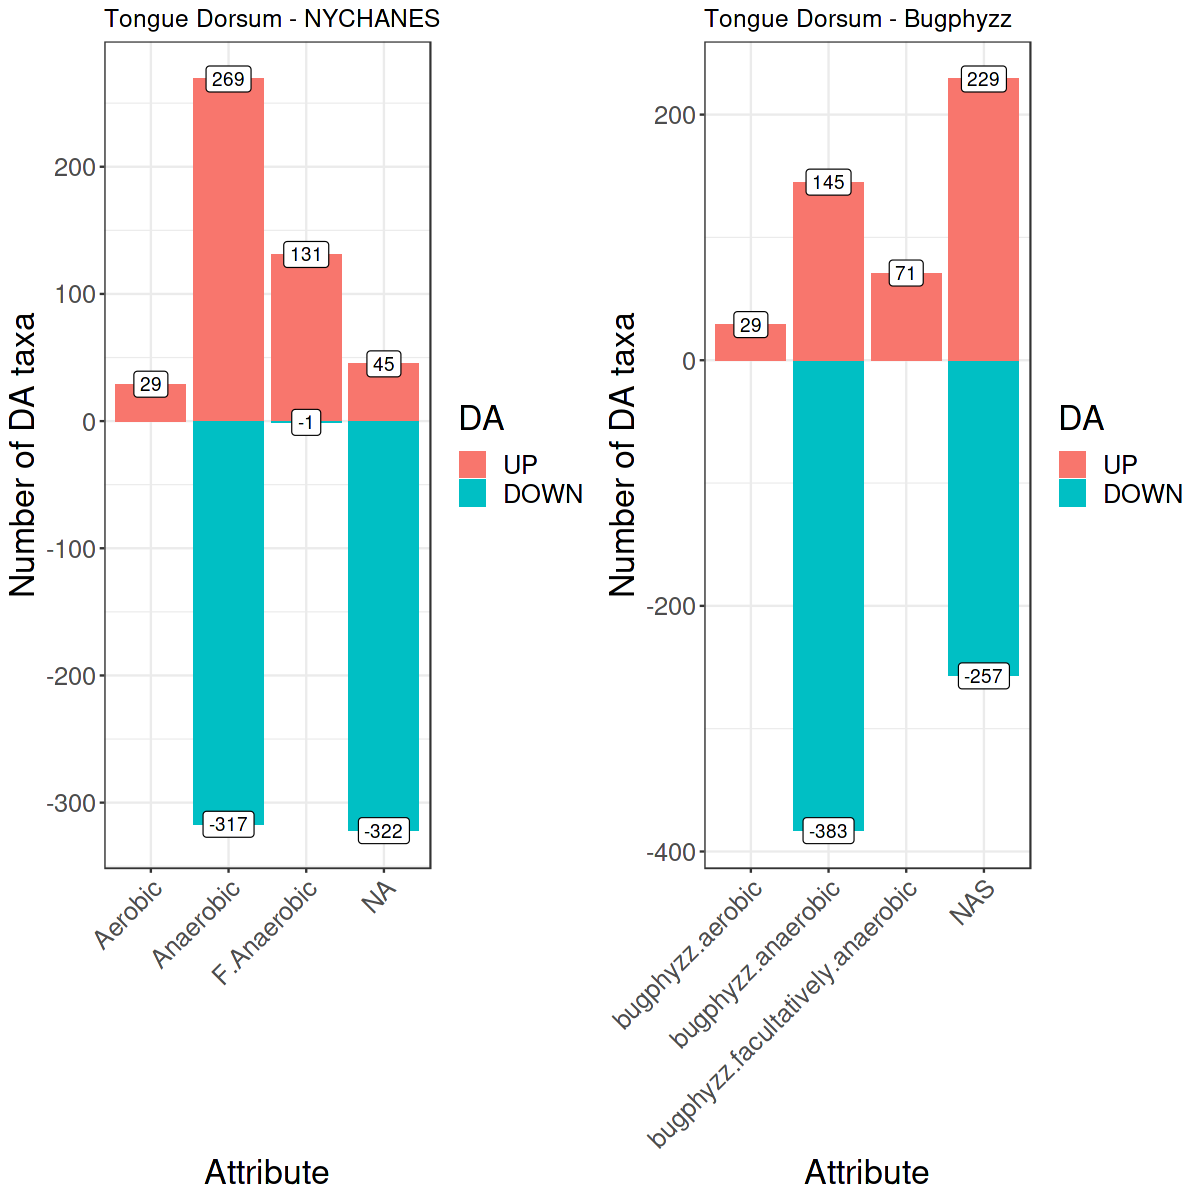

In [23]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggpubr::ggarrange(p1, p2, align = "h")

## Enrichment Fisher

In [24]:
# Convert from deseq object to SummarizedExperiment
seDESEQ <- SummarizedExperiment::SummarizedExperiment(
    assays = S4Vectors::SimpleList(counts = counts(dds)),
    rowData = rowData(dds),
    colData = colData(dds)
)

In [25]:
seDESEQ

class: SummarizedExperiment 
dim: 1298 78 
metadata(0):
assays(1): counts
rownames(1298): OTU_97.37504 OTU_97.34346 ... OTU_97.45365 OTU_97.45307
rowData names(47): SUPERKINGDOM PHYLUM ... DA.UP DA.DOWN
colnames(78): 700023058 700023227 ... 700114000 700114717
colData names(10): RSID VISITNO ... sizeFactor replaceable

### NYC HANES

In [26]:
nyc_hanes_attributes <- c("nychanes.Aerobic", "nychanes.Anaerobic", "nychanes.F.Anaerobic")
contingency_tbls_nychanes <- contingencyTable(seDESEQ, diffcols = c("DA.UP", "DA.DOWN"), sigcols = nyc_hanes_attributes)

In [27]:
lapply(contingency_tbls_nychanes, function(x) knitr::kable(x))

$DA.UP_nychanes.Aerobic


|        | nychanes.Aerobic| Notnychanes.Aerobic|
|:-------|----------------:|-------------------:|
|Diff    |               29|                 445|
|NotDiff |               14|                 810|

$DA.UP_nychanes.Anaerobic


|        | nychanes.Anaerobic| Notnychanes.Anaerobic|
|:-------|------------------:|---------------------:|
|Diff    |                269|                   205|
|NotDiff |                406|                   418|

$DA.UP_nychanes.F.Anaerobic


|        | nychanes.F.Anaerobic| Notnychanes.F.Anaerobic|
|:-------|--------------------:|-----------------------:|
|Diff    |                  131|                     343|
|NotDiff |                    3|                     821|

$DA.DOWN_nychanes.Aerobic


|        | nychanes.Aerobic| Notnychanes.Aerobic|
|:-------|----------------:|-------------------:|
|Diff    |                0|                 640|
|NotDiff |               43|                 615|

$DA.DOWN_nychanes.Anaerobic


|     

In [28]:
fisher_nychanes <- enrichmentTest(contingency_tbls_nychanes) %>% 
    suppressWarnings() %>% 
    separate(col = con.table, into = c("Direction", "Attribute"), sep = "_") %>% 
    mutate(Direction = sub("^DA\\.", "", Direction), Attribute = sub("nychanes\\.", "", Attribute))

In [29]:
fisher_nychanes

Direction,Attribute,p.value,odds.ratio,ci.up,ci.lo
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,F.Anaerobic,1.396081e-58,89.854231649,244.90175361,32.967436232
UP,Aerobic,2.787143e-05,3.701342931,6.95304647,1.970350632
UP,Anaerobic,5.519067e-03,1.350149487,1.69403998,1.076068841
DOWN,Anaerobic,9.651442e-01,0.822668296,1.02277070,0.661715400
DOWN,F.Anaerobic,1.000000e+00,0.009232986,0.03747871,0.002274572
DOWN,Aerobic,1.000000e+00,0.011045609,0.08042002,0.001517103


#### Plot of Odds Ratio

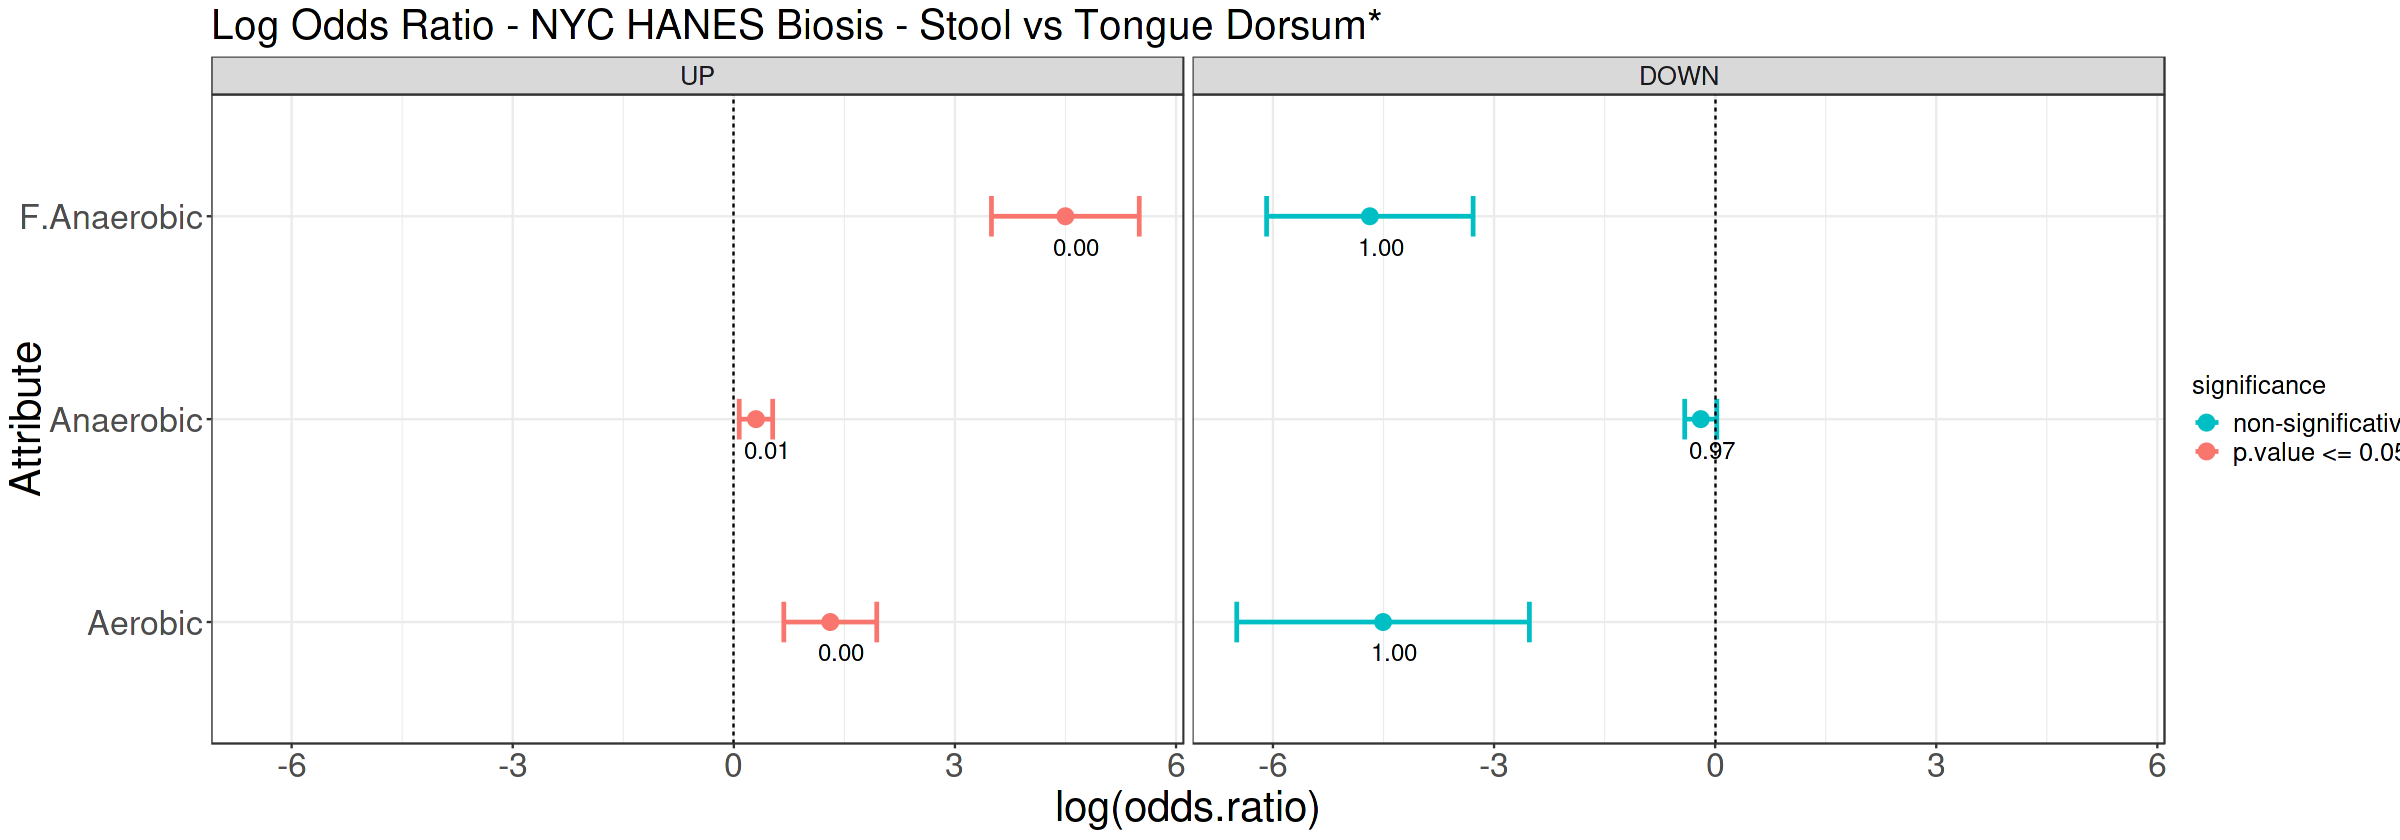

In [30]:
options(repr.plot.width = 20, repr.plot.height = 7)
(
p3 <- fisher_nychanes %>% 
    mutate(Direction = factor(Direction, levels = c("UP", "DOWN")),
          significance = ifelse(p.value <= 0.05, "p.value <= 0.05", "non-significative")) %>% 
    ggplot(aes(Attribute, log(odds.ratio))) +
    geom_point(aes(color = significance), size = 4) +
    geom_text(aes(label = sprintf("%0.2f", round(p.value, digits = 2))), nudge_y = 0.15, nudge_x = -0.15, size = 5) +
    geom_errorbar(aes(ymin = log(ci.lo), ymax = log(ci.up), color = significance), width = 0.2, size = 1) +
    geom_hline(yintercept = log(1), linetype = 2) +
    facet_wrap(~Direction) +
    scale_color_discrete(direction = -1) +
    labs(title = "Log Odds Ratio - NYC HANES Biosis - Stool vs Tongue Dorsum*") +   
    theme_bw() +
    theme(title = element_text(size = 20),
        axis.text = element_text(size = 20),
        axis.title = element_text(size = 25),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 15),
        strip.text = element_text(size = 15)
    ) +
    coord_flip()
)

In [31]:
bugphyzz_attributes <- c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic")
contingency_tbls_bugphyzz <- contingencyTable(seDESEQ, diffcols = c("DA.UP", "DA.DOWN"), sigcols = bugphyzz_attributes)

In [32]:
lapply(contingency_tbls_bugphyzz, function(x) knitr::kable(x))

$DA.UP_bugphyzz.aerobic


|        | bugphyzz.aerobic| Notbugphyzz.aerobic|
|:-------|----------------:|-------------------:|
|Diff    |               29|                 445|
|NotDiff |               13|                 811|

$DA.UP_bugphyzz.anaerobic


|        | bugphyzz.anaerobic| Notbugphyzz.anaerobic|
|:-------|------------------:|---------------------:|
|Diff    |                145|                   329|
|NotDiff |                480|                   344|

$DA.UP_bugphyzz.facultatively.anaerobic


|        | bugphyzz.facultatively.anaerobic| Notbugphyzz.facultatively.anaerobic|
|:-------|--------------------------------:|-----------------------------------:|
|Diff    |                               71|                                 403|
|NotDiff |                                2|                                 822|

$DA.DOWN_bugphyzz.aerobic


|        | bugphyzz.aerobic| Notbugphyzz.aerobic|
|:-------|----------------:|-------------------:|
|Diff    |                0| 

In [33]:
fisher_bugphyzz <- enrichmentTest(contingency_tbls_bugphyzz) %>% 
    suppressWarnings() %>% 
    separate(col = con.table, into = c("Direction", "Attribute"), sep = "_") %>% 
    mutate(Direction = sub("^DA\\.", "", Direction), Attribute = sub("bugphyzz\\.", "", Attribute))

In [34]:
fisher_bugphyzz

Direction,Attribute,p.value,odds.ratio,ci.up,ci.lo
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,facultatively.anaerobic,2.919184e-30,58.298636927,186.16641634,1.825641e+01
DOWN,anaerobic,5.417542e-17,2.557946152,3.19831041,2.045795e+00
UP,aerobic,1.373140e-05,3.980421499,7.58529562,2.088746e+00
DOWN,facultatively.anaerobic,1.000000e+00,0.006218569,0.04487657,8.617102e-04
DOWN,aerobic,1.000000e+00,0.011323874,0.08248794,1.554532e-03
UP,anaerobic,1.000000e+00,0.316594531,0.40202982,2.493151e-01


#### Plot of odds ratio

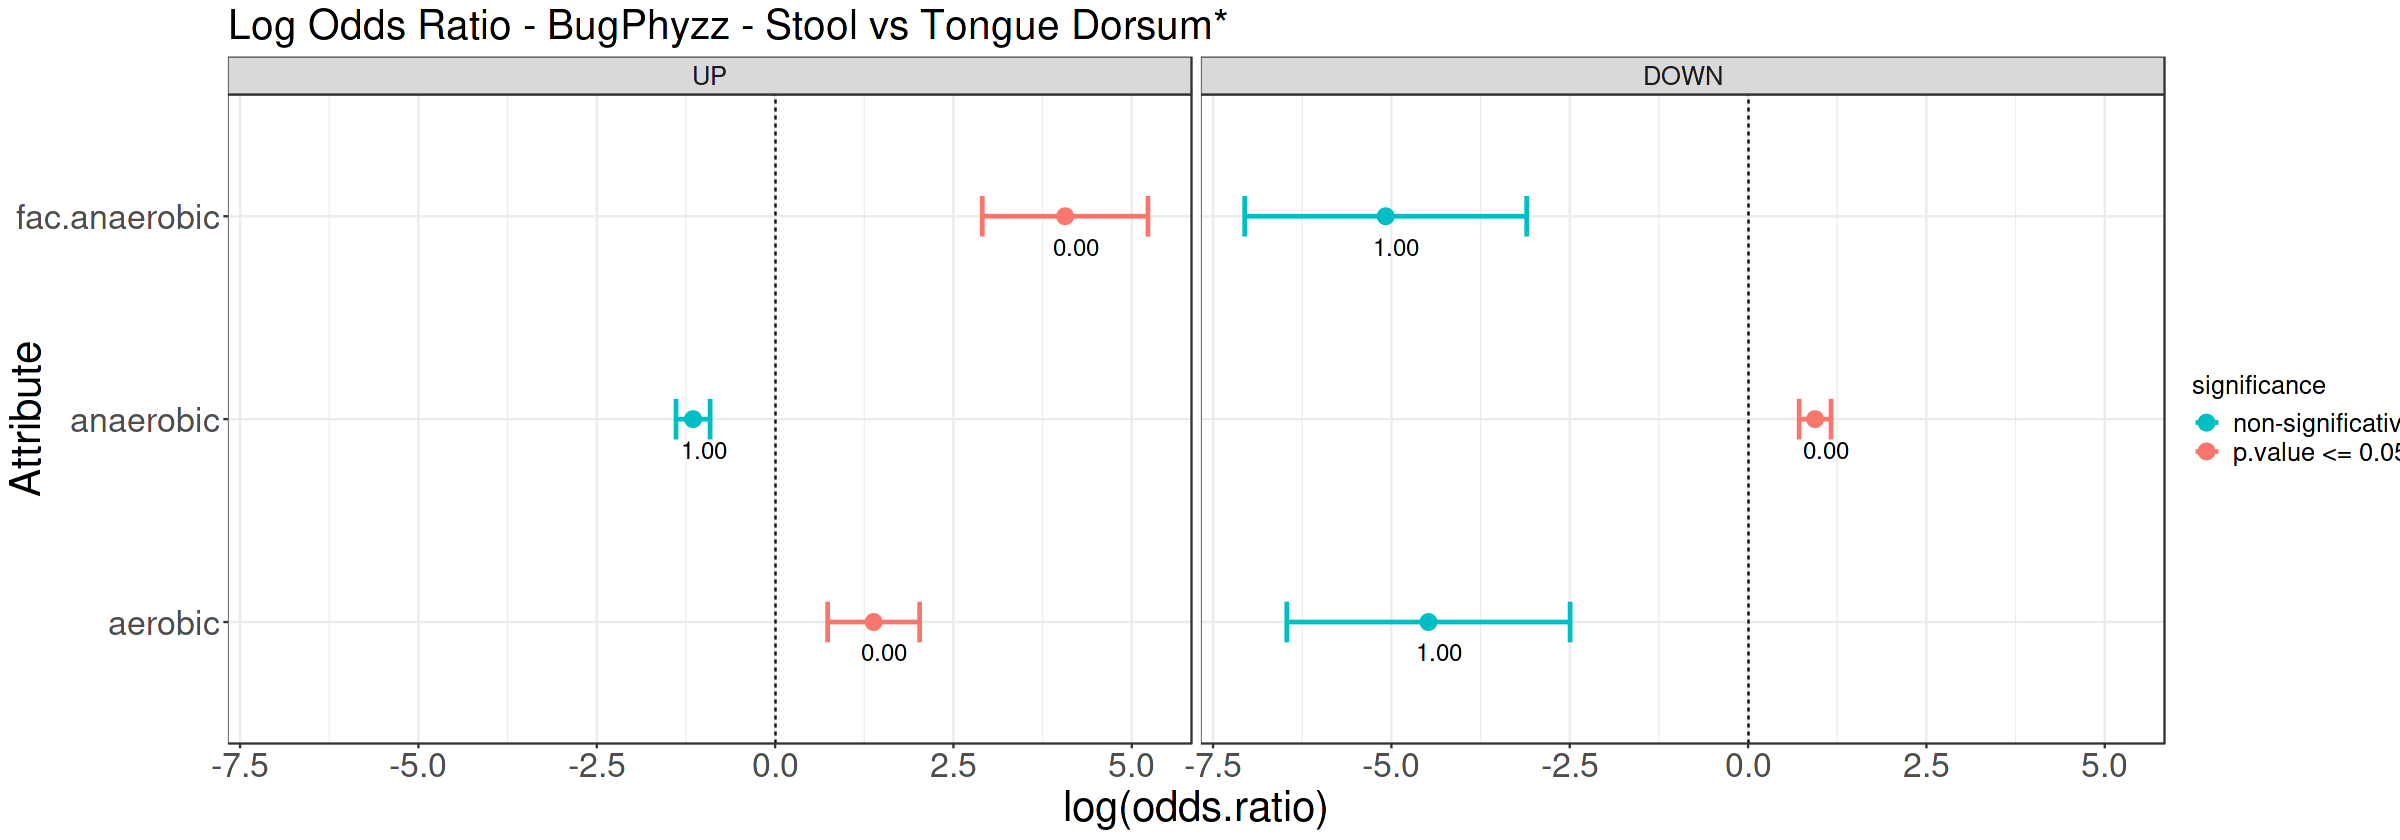

In [35]:
options(repr.plot.width = 20, repr.plot.height = 7)
(
p4 <- fisher_bugphyzz %>% 
    mutate(Direction = factor(Direction, levels = c("UP", "DOWN")),
          significance = ifelse(p.value <= 0.05, "p.value <= 0.05", "non-significative"))  %>% 
    ggplot(aes(Attribute, log(odds.ratio))) +
    geom_text(aes(label = sprintf("%0.2f", round(p.value, digits = 2))), nudge_y = 0.15, nudge_x = -0.15, size = 5) +
    geom_point(aes(color = significance), size = 4) +
    geom_errorbar(aes(ymin = log(ci.lo), ymax = log(ci.up), color = significance), width = 0.2, size = 1) +
    geom_hline(yintercept = log(1), linetype = 2) +
    facet_wrap(~Direction) +
    scale_color_discrete(direction = -1) +
    scale_x_discrete(labels = c("aerobic", "anaerobic", "fac.anaerobic")) +
    labs(title = "Log Odds Ratio - BugPhyzz - Stool vs Tongue Dorsum*") +
    theme_bw() +
    theme(title = element_text(size = 20),
        axis.text = element_text(size = 20),
        axis.title = element_text(size = 25),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 15),
        strip.text = element_text(size = 15)
    ) +
    coord_flip()
)

### Enrichment Browser

In [36]:
nychanes_sets = microbeScores::makeMicrobeSets(x = seDESEQ, cols = c("nychanes.Aerobic", "nychanes.Anaerobic", "nychanes.F.Anaerobic"))

In [37]:
seDESEQ_ora_nychanes_default <- EnrichmentBrowser::sbea(method = "ora", se = seDESEQ,  gs = nychanes_sets, alpha = 0.1, perm=0)

In [38]:
EnrichmentBrowser::gsRanking(seDESEQ_ora_nychanes_default, signif.only = FALSE)

DataFrame with 2 rows and 4 columns
              GENE.SET  NR.GENES NR.SIG.GENES      PVAL
           <character> <numeric>    <numeric> <numeric>
1 nychanes.F.Anaerobic       134          132  4.28e-07
2     nychanes.Aerobic        41           29  1.00e+00

In [39]:
bugphyzz_sets <- microbeScores::makeMicrobeSets(x = seDESEQ, cols = c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic"))

In [40]:
EnrichmentBrowser::sbea(method = "ora", se = seDESEQ, gs = bugphyzz_sets, alpha = 0.1, perm = 0) %>% 
    EnrichmentBrowser::gsRanking(signif.only = FALSE) # None was found significative

DataFrame with 2 rows and 4 columns
                GENE.SET  NR.GENES NR.SIG.GENES      PVAL
             <character> <numeric>    <numeric> <numeric>
1 bugphyzz.facultative..        73           71  7.06e-05
2       bugphyzz.aerobic        41           29  1.00e+00